In [2]:
import cv2
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from pathlib import Path
import os
from PIL import ImageFile,Image,ImageEnhance
import random


In [3]:
TRAIN_PATH= './input/training/training/'
VALID_PATH = './input/validation/validation/'

In [4]:
#label info
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("./input/monkey_labels.txt", names=cols, skiprows=1)
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


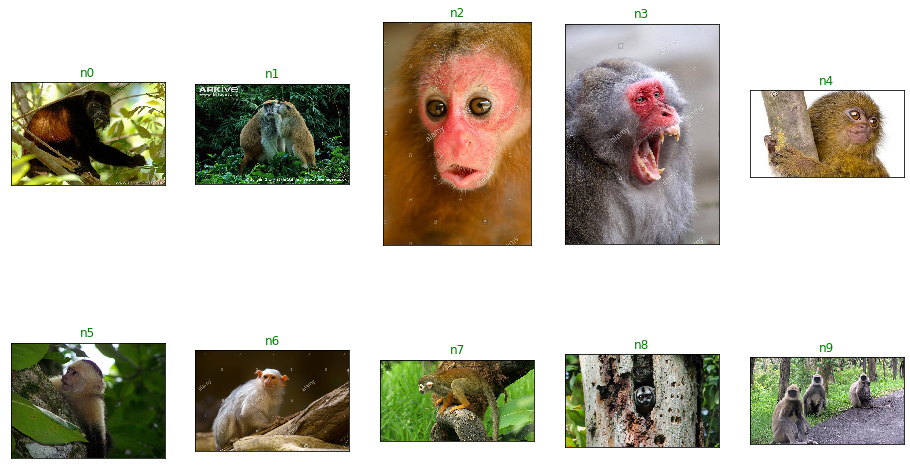

In [5]:
# 各类猴子展示
train_paths = os.listdir(TRAIN_PATH)

fig = plt.figure(figsize=(16, 9))
for i, class_path in enumerate(train_paths):
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    monkey_paths = os.listdir(os.path.join(TRAIN_PATH,class_path))
    monkey_path = os.path.join(TRAIN_PATH,class_path,monkey_paths[0])
    image=Image.open(monkey_path)
    ax.imshow(image)
    ax.set_title("{}".format(class_path),color="green")

数据增强中可选的一些图像处理操作

In [6]:
def image_rotation(image, angle=0):
    """ 旋转图片 """
    # 获取图像的尺寸
    # 旋转中心
    # angle = random.uniform(-15, 15)
    (h, w) = image.shape[:2]
    (cx, cy) = (w / 2, h / 2)
    # 设置旋转矩阵
    M = cv2.getRotationMatrix2D((cx, cy), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # 计算图像旋转后的新边界
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # 调整旋转矩阵的移动距离（t_{x}, t_{y}）
    M[0, 2] += (nW / 2) - cx
    M[1, 2] += (nH / 2) - cy
    return cv2.warpAffine(image, M, (nW, nH), borderValue=(255, 255, 255))


def sp_noise(image, prob=0.01):
    """
    添加椒盐噪声
    prob:噪声比例
    """
    # prob = random.random() * 0.01
    output = np.zeros(image.shape, np.uint8)
    thresh = 1 - prob
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thresh:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output


def gauss_noise(image, mean=0, var=0.001):
    """
        添加高斯噪声
        mean : 均值
        var : 方差
    """
    # mean = 0
    # var = random.random() * 0.001
    image = np.array(image / 255, dtype=float)
    noise = np.random.normal(mean, var ** 0.5, image.shape)
    out = image + noise
    if out.min() < 0:
        low_clip = -1.
    else:
        low_clip = 0.
    out = np.clip(out, low_clip, 1.0)
    out = np.uint8(out * 255)
    return out


def image_enhance(image, factors):
    """色彩抖动"""
    # random_factors为含4个随机数的列表，取值范围为[0.0, 1.0]
    # random_factors = [random.uniform(0.5, 1.5),
    #                  random.uniform(0.9, 1),
    #                  random.uniform(0.5, 1),
    #                  random.uniform(0.5, 1)]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    # 调整图像的饱和度
    color_img = ImageEnhance.Color(image).enhance(factors[0])
    # 调整图像的亮度
    brightness_img = ImageEnhance.Brightness(color_img).enhance(factors[1])
    # 调整图像对比度
    contrast_img = ImageEnhance.Contrast(brightness_img).enhance(factors[2])
    # 调整图像锐度
    sharpness_img = ImageEnhance.Sharpness(contrast_img).enhance(factors[3])

    sharpness_img = np.asarray(sharpness_img)
    sharpness_img = cv2.cvtColor(sharpness_img, cv2.COLOR_RGB2BGR)
    return sharpness_img


def image_blur(image, choice=1):
    """图像模糊"""
    # random_factor为1至4中的一个，根据其值从四种滤波中选择一种
    # choice = [1, 2, 3, 4]
    # random_factor = random.choice(choice)
    random_factor = choice
    if random_factor == 1:
        blur_img = cv2.blur(image, (3, 3))
    elif random_factor == 2:
        blur_img = cv2.GaussianBlur(image, (3, 3), 0)
    elif random_factor == 3:
        blur_img = cv2.bilateralFilter(image, 3, 75, 75)
    elif random_factor == 4:
        blur_img = cv2.medianBlur(image, 3)
    else:
        blur_img = image
    return blur_img


def image_resize(image, size=1.0):
    # random_factor为放大缩小的倍数
    # random_factor = random.uniform(0.8, 1.5)
    random_factor = size
    img_resize = cv2.resize(np.asarray(image), None, fx=random_factor, fy=random_factor)
    return img_resize

def image_cut(img, left, below):
    # 裁剪 a,b为左边和下边裁掉的比例
    img_cut = img[:int((img.shape[0] - 1) * (1 - below)), int((img.shape[1] - 1) * left):]
    return img_cut

def save_image(name, image):
    # img_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # filename = name + ".jpg"
    cv2.imwrite(name, image)
    

依次加载各个猴子的照片进行数据增强，各个增强函数的控制数值采用随机数

In [12]:
# 各类猴子数据增强
train_paths = os.listdir(TRAIN_PATH)

fig = plt.figure(figsize=(16, 9))
for i, class_path in enumerate(train_paths):
    monkey_paths = os.listdir(os.path.join(TRAIN_PATH,class_path))
    for j, monkey_filename in enumerate(monkey_paths):
        monkey_path = os.path.join(TRAIN_PATH,class_path,monkey_filename)
        print(monkey_path)
        image=Image.open(monkey_path)
        image = np.asarray(image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        for k in range(2):
            img = image.copy()
            # 放缩
            img = image_resize(img, size=random.uniform(0.8, 1.5))
            # 随机裁剪
            img = image_cut(img, left=random.uniform(0, 0.1), below=random.uniform(0, 0.1))
            # 高斯噪声
            img = gauss_noise(img, mean=0, var=random.uniform(0, 0.001))
            # 色彩抖动
            random_factors = [random.uniform(0.5, 1.5),
                              random.uniform(0.9, 1),
                              random.uniform(0.5, 1),
                              random.uniform(0.5, 1.5)]
            img = image_enhance(img, factors=random_factors)
            
            new_path = os.path.join(TRAIN_PATH,class_path,'picture_{}{}{}.jpg'.format(i,j,k))
            print(new_path)
            save_image(new_path, img)

./input/training/training/n0\n0018.jpg
./input/training/training/n0\picture_000.jpg
./input/training/training/n0\picture_001.jpg
./input/training/training/n0\n0019.jpg
./input/training/training/n0\picture_010.jpg
./input/training/training/n0\picture_011.jpg
./input/training/training/n0\n0020.jpg
./input/training/training/n0\picture_020.jpg
./input/training/training/n0\picture_021.jpg
./input/training/training/n0\n0021.jpg
./input/training/training/n0\picture_030.jpg
./input/training/training/n0\picture_031.jpg
./input/training/training/n0\n0022.jpg
./input/training/training/n0\picture_040.jpg
./input/training/training/n0\picture_041.jpg
./input/training/training/n0\n0023.jpg
./input/training/training/n0\picture_050.jpg
./input/training/training/n0\picture_051.jpg
./input/training/training/n0\n0024.jpg
./input/training/training/n0\picture_060.jpg
./input/training/training/n0\picture_061.jpg
./input/training/training/n0\n0025.jpg
./input/training/training/n0\picture_070.jpg
./input/train

./input/training/training/n0\picture_0630.jpg
./input/training/training/n0\picture_0631.jpg
./input/training/training/n0\n0138.jpg
./input/training/training/n0\picture_0640.jpg
./input/training/training/n0\picture_0641.jpg
./input/training/training/n0\n0139.jpg
./input/training/training/n0\picture_0650.jpg
./input/training/training/n0\picture_0651.jpg
./input/training/training/n0\n0140.jpg
./input/training/training/n0\picture_0660.jpg
./input/training/training/n0\picture_0661.jpg
./input/training/training/n0\n0141.jpg
./input/training/training/n0\picture_0670.jpg
./input/training/training/n0\picture_0671.jpg
./input/training/training/n0\n0142.jpg
./input/training/training/n0\picture_0680.jpg
./input/training/training/n0\picture_0681.jpg
./input/training/training/n0\n0143.jpg
./input/training/training/n0\picture_0690.jpg
./input/training/training/n0\picture_0691.jpg
./input/training/training/n0\n0144.jpg
./input/training/training/n0\picture_0700.jpg
./input/training/training/n0\picture_

./input/training/training/n1\picture_1270.jpg
./input/training/training/n1\picture_1271.jpg
./input/training/training/n1\n1046.jpg
./input/training/training/n1\picture_1280.jpg
./input/training/training/n1\picture_1281.jpg
./input/training/training/n1\n1047.jpg
./input/training/training/n1\picture_1290.jpg
./input/training/training/n1\picture_1291.jpg
./input/training/training/n1\n1048.jpg
./input/training/training/n1\picture_1300.jpg
./input/training/training/n1\picture_1301.jpg
./input/training/training/n1\n1049.jpg
./input/training/training/n1\picture_1310.jpg
./input/training/training/n1\picture_1311.jpg
./input/training/training/n1\n1050.jpg
./input/training/training/n1\picture_1320.jpg
./input/training/training/n1\picture_1321.jpg
./input/training/training/n1\n1051.jpg
./input/training/training/n1\picture_1330.jpg
./input/training/training/n1\picture_1331.jpg
./input/training/training/n1\n1052.jpg
./input/training/training/n1\picture_1340.jpg
./input/training/training/n1\picture_

./input/training/training/n1\picture_1900.jpg
./input/training/training/n1\picture_1901.jpg
./input/training/training/n1\n1146.jpg
./input/training/training/n1\picture_1910.jpg
./input/training/training/n1\picture_1911.jpg
./input/training/training/n1\n1147.jpg
./input/training/training/n1\picture_1920.jpg
./input/training/training/n1\picture_1921.jpg
./input/training/training/n1\n1148.jpg
./input/training/training/n1\picture_1930.jpg
./input/training/training/n1\picture_1931.jpg
./input/training/training/n1\n1149.jpg
./input/training/training/n1\picture_1940.jpg
./input/training/training/n1\picture_1941.jpg
./input/training/training/n1\n1150.jpg
./input/training/training/n1\picture_1950.jpg
./input/training/training/n1\picture_1951.jpg
./input/training/training/n1\n1151.jpg
./input/training/training/n1\picture_1960.jpg
./input/training/training/n1\picture_1961.jpg
./input/training/training/n1\n1152.jpg
./input/training/training/n1\picture_1970.jpg
./input/training/training/n1\picture_

./input/training/training/n2\picture_2470.jpg
./input/training/training/n2\picture_2471.jpg
./input/training/training/n2\n2065.jpg
./input/training/training/n2\picture_2480.jpg
./input/training/training/n2\picture_2481.jpg
./input/training/training/n2\n2066.jpg
./input/training/training/n2\picture_2490.jpg
./input/training/training/n2\picture_2491.jpg
./input/training/training/n2\n2067.jpg
./input/training/training/n2\picture_2500.jpg
./input/training/training/n2\picture_2501.jpg
./input/training/training/n2\n2068.jpg
./input/training/training/n2\picture_2510.jpg
./input/training/training/n2\picture_2511.jpg
./input/training/training/n2\n2069.jpg
./input/training/training/n2\picture_2520.jpg
./input/training/training/n2\picture_2521.jpg
./input/training/training/n2\n2110.jpg
./input/training/training/n2\picture_2530.jpg
./input/training/training/n2\picture_2531.jpg
./input/training/training/n2\n2111.jpg
./input/training/training/n2\picture_2540.jpg
./input/training/training/n2\picture_

./input/training/training/n3\picture_350.jpg
./input/training/training/n3\picture_351.jpg
./input/training/training/n3\n3026.jpg
./input/training/training/n3\picture_360.jpg
./input/training/training/n3\picture_361.jpg
./input/training/training/n3\n3027.jpg
./input/training/training/n3\picture_370.jpg
./input/training/training/n3\picture_371.jpg
./input/training/training/n3\n3028.jpg
./input/training/training/n3\picture_380.jpg
./input/training/training/n3\picture_381.jpg
./input/training/training/n3\n3029.jpg
./input/training/training/n3\picture_390.jpg
./input/training/training/n3\picture_391.jpg
./input/training/training/n3\n3030.jpg
./input/training/training/n3\picture_3100.jpg
./input/training/training/n3\picture_3101.jpg
./input/training/training/n3\n3031.jpg
./input/training/training/n3\picture_3110.jpg
./input/training/training/n3\picture_3111.jpg
./input/training/training/n3\n3032.jpg
./input/training/training/n3\picture_3120.jpg
./input/training/training/n3\picture_3121.jpg
.

./input/training/training/n3\picture_3680.jpg
./input/training/training/n3\picture_3681.jpg
./input/training/training/n3\n3120.jpg
./input/training/training/n3\picture_3690.jpg
./input/training/training/n3\picture_3691.jpg
./input/training/training/n3\n3121.jpg
./input/training/training/n3\picture_3700.jpg
./input/training/training/n3\picture_3701.jpg
./input/training/training/n3\n3122.jpg
./input/training/training/n3\picture_3710.jpg
./input/training/training/n3\picture_3711.jpg
./input/training/training/n3\n3123.jpg
./input/training/training/n3\picture_3720.jpg
./input/training/training/n3\picture_3721.jpg
./input/training/training/n3\n3124.jpg
./input/training/training/n3\picture_3730.jpg
./input/training/training/n3\picture_3731.jpg
./input/training/training/n3\n3125.jpg
./input/training/training/n3\picture_3740.jpg
./input/training/training/n3\picture_3741.jpg
./input/training/training/n3\n3126.jpg
./input/training/training/n3\picture_3750.jpg
./input/training/training/n3\picture_

./input/training/training/n4\picture_4140.jpg
./input/training/training/n4\picture_4141.jpg
./input/training/training/n4\n4031.jpg
./input/training/training/n4\picture_4150.jpg
./input/training/training/n4\picture_4151.jpg
./input/training/training/n4\n4032.jpg
./input/training/training/n4\picture_4160.jpg
./input/training/training/n4\picture_4161.jpg
./input/training/training/n4\n4033.jpg
./input/training/training/n4\picture_4170.jpg
./input/training/training/n4\picture_4171.jpg
./input/training/training/n4\n4034.jpg
./input/training/training/n4\picture_4180.jpg
./input/training/training/n4\picture_4181.jpg
./input/training/training/n4\n4035.jpg
./input/training/training/n4\picture_4190.jpg
./input/training/training/n4\picture_4191.jpg
./input/training/training/n4\n4036.jpg
./input/training/training/n4\picture_4200.jpg
./input/training/training/n4\picture_4201.jpg
./input/training/training/n4\n4037.jpg
./input/training/training/n4\picture_4210.jpg
./input/training/training/n4\picture_

./input/training/training/n4\picture_4770.jpg
./input/training/training/n4\picture_4771.jpg
./input/training/training/n4\n4139.jpg
./input/training/training/n4\picture_4780.jpg
./input/training/training/n4\picture_4781.jpg
./input/training/training/n4\n4140.jpg
./input/training/training/n4\picture_4790.jpg
./input/training/training/n4\picture_4791.jpg
./input/training/training/n4\n4141.jpg
./input/training/training/n4\picture_4800.jpg
./input/training/training/n4\picture_4801.jpg
./input/training/training/n4\n4142.jpg
./input/training/training/n4\picture_4810.jpg
./input/training/training/n4\picture_4811.jpg
./input/training/training/n4\n4143.jpg
./input/training/training/n4\picture_4820.jpg
./input/training/training/n4\picture_4821.jpg
./input/training/training/n4\n4144.jpg
./input/training/training/n4\picture_4830.jpg
./input/training/training/n4\picture_4831.jpg
./input/training/training/n4\n4145.jpg
./input/training/training/n4\picture_4840.jpg
./input/training/training/n4\picture_

./input/training/training/n5\picture_5401.jpg
./input/training/training/n5\n5059.jpg
./input/training/training/n5\picture_5410.jpg
./input/training/training/n5\picture_5411.jpg
./input/training/training/n5\n5060.jpg
./input/training/training/n5\picture_5420.jpg
./input/training/training/n5\picture_5421.jpg
./input/training/training/n5\n5061.jpg
./input/training/training/n5\picture_5430.jpg
./input/training/training/n5\picture_5431.jpg
./input/training/training/n5\n5062.jpg
./input/training/training/n5\picture_5440.jpg
./input/training/training/n5\picture_5441.jpg
./input/training/training/n5\n5063.jpg
./input/training/training/n5\picture_5450.jpg
./input/training/training/n5\picture_5451.jpg
./input/training/training/n5\n5064.jpg
./input/training/training/n5\picture_5460.jpg
./input/training/training/n5\picture_5461.jpg
./input/training/training/n5\n5065.jpg
./input/training/training/n5\picture_5470.jpg
./input/training/training/n5\picture_5471.jpg
./input/training/training/n5\n5066.jp

./input/training/training/n5\picture_51031.jpg
./input/training/training/n5\n5158.jpg
./input/training/training/n5\picture_51040.jpg
./input/training/training/n5\picture_51041.jpg
./input/training/training/n5\n5159.jpg
./input/training/training/n5\picture_51050.jpg
./input/training/training/n5\picture_51051.jpg
./input/training/training/n5\n5160.jpg
./input/training/training/n5\picture_51060.jpg
./input/training/training/n5\picture_51061.jpg
./input/training/training/n5\n5161.jpg
./input/training/training/n5\picture_51070.jpg
./input/training/training/n5\picture_51071.jpg
./input/training/training/n6\n6016.jpg
./input/training/training/n6\picture_600.jpg
./input/training/training/n6\picture_601.jpg
./input/training/training/n6\n6017.jpg
./input/training/training/n6\picture_610.jpg
./input/training/training/n6\picture_611.jpg
./input/training/training/n6\n6018.jpg
./input/training/training/n6\picture_620.jpg
./input/training/training/n6\picture_621.jpg
./input/training/training/n6\n6019

./input/training/training/n6\picture_6581.jpg
./input/training/training/n6\n6115.jpg
./input/training/training/n6\picture_6590.jpg
./input/training/training/n6\picture_6591.jpg
./input/training/training/n6\n6116.jpg
./input/training/training/n6\picture_6600.jpg
./input/training/training/n6\picture_6601.jpg
./input/training/training/n6\n6117.jpg
./input/training/training/n6\picture_6610.jpg
./input/training/training/n6\picture_6611.jpg
./input/training/training/n6\n6118.jpg
./input/training/training/n6\picture_6620.jpg
./input/training/training/n6\picture_6621.jpg
./input/training/training/n6\n6119.jpg
./input/training/training/n6\picture_6630.jpg
./input/training/training/n6\picture_6631.jpg
./input/training/training/n6\n6120.jpg
./input/training/training/n6\picture_6640.jpg
./input/training/training/n6\picture_6641.jpg
./input/training/training/n6\n6121.jpg
./input/training/training/n6\picture_6650.jpg
./input/training/training/n6\picture_6651.jpg
./input/training/training/n6\n6122.jp

./input/training/training/n7\picture_7201.jpg
./input/training/training/n7\n7039.jpg
./input/training/training/n7\picture_7210.jpg
./input/training/training/n7\picture_7211.jpg
./input/training/training/n7\n7040.jpg
./input/training/training/n7\picture_7220.jpg
./input/training/training/n7\picture_7221.jpg
./input/training/training/n7\n7041.jpg
./input/training/training/n7\picture_7230.jpg
./input/training/training/n7\picture_7231.jpg
./input/training/training/n7\n7042.jpg
./input/training/training/n7\picture_7240.jpg
./input/training/training/n7\picture_7241.jpg
./input/training/training/n7\n7043.jpg
./input/training/training/n7\picture_7250.jpg
./input/training/training/n7\picture_7251.jpg
./input/training/training/n7\n7044.jpg
./input/training/training/n7\picture_7260.jpg
./input/training/training/n7\picture_7261.jpg
./input/training/training/n7\n7045.jpg
./input/training/training/n7\picture_7270.jpg
./input/training/training/n7\picture_7271.jpg
./input/training/training/n7\n7046.jp

./input/training/training/n7\picture_7830.jpg
./input/training/training/n7\picture_7831.jpg
./input/training/training/n7\n7140.jpg
./input/training/training/n7\picture_7840.jpg
./input/training/training/n7\picture_7841.jpg
./input/training/training/n7\n7141.jpg
./input/training/training/n7\picture_7850.jpg
./input/training/training/n7\picture_7851.jpg
./input/training/training/n7\n7142.jpg
./input/training/training/n7\picture_7860.jpg
./input/training/training/n7\picture_7861.jpg
./input/training/training/n7\n7143.jpg
./input/training/training/n7\picture_7870.jpg
./input/training/training/n7\picture_7871.jpg
./input/training/training/n7\n7144.jpg
./input/training/training/n7\picture_7880.jpg
./input/training/training/n7\picture_7881.jpg
./input/training/training/n7\n7145.jpg
./input/training/training/n7\picture_7890.jpg
./input/training/training/n7\picture_7891.jpg
./input/training/training/n7\n7146.jpg
./input/training/training/n7\picture_7900.jpg
./input/training/training/n7\picture_

./input/training/training/n8\picture_8371.jpg
./input/training/training/n8\n8058.jpg
./input/training/training/n8\picture_8380.jpg
./input/training/training/n8\picture_8381.jpg
./input/training/training/n8\n8059.jpg
./input/training/training/n8\picture_8390.jpg
./input/training/training/n8\picture_8391.jpg
./input/training/training/n8\n8060.jpg
./input/training/training/n8\picture_8400.jpg
./input/training/training/n8\picture_8401.jpg
./input/training/training/n8\n8061.jpg
./input/training/training/n8\picture_8410.jpg
./input/training/training/n8\picture_8411.jpg
./input/training/training/n8\n8062.jpg
./input/training/training/n8\picture_8420.jpg
./input/training/training/n8\picture_8421.jpg
./input/training/training/n8\n8063.jpg
./input/training/training/n8\picture_8430.jpg
./input/training/training/n8\picture_8431.jpg
./input/training/training/n8\n8064.jpg
./input/training/training/n8\picture_8440.jpg
./input/training/training/n8\picture_8441.jpg
./input/training/training/n8\n8065.jp

./input/training/training/n8\picture_81001.jpg
./input/training/training/n9\n9014.jpg
./input/training/training/n9\picture_900.jpg
./input/training/training/n9\picture_901.jpg
./input/training/training/n9\n9016.jpg
./input/training/training/n9\picture_910.jpg
./input/training/training/n9\picture_911.jpg
./input/training/training/n9\n9017.jpg
./input/training/training/n9\picture_920.jpg
./input/training/training/n9\picture_921.jpg
./input/training/training/n9\n9018.jpg
./input/training/training/n9\picture_930.jpg
./input/training/training/n9\picture_931.jpg
./input/training/training/n9\n9019.jpg
./input/training/training/n9\picture_940.jpg
./input/training/training/n9\picture_941.jpg
./input/training/training/n9\n9020.jpg
./input/training/training/n9\picture_950.jpg
./input/training/training/n9\picture_951.jpg
./input/training/training/n9\n9022.jpg
./input/training/training/n9\picture_960.jpg
./input/training/training/n9\picture_961.jpg
./input/training/training/n9\n9023.jpg
./input/tra

./input/training/training/n9\picture_9621.jpg
./input/training/training/n9\n9124.jpg
./input/training/training/n9\picture_9630.jpg
./input/training/training/n9\picture_9631.jpg
./input/training/training/n9\n9125.jpg
./input/training/training/n9\picture_9640.jpg
./input/training/training/n9\picture_9641.jpg
./input/training/training/n9\n9126.jpg
./input/training/training/n9\picture_9650.jpg
./input/training/training/n9\picture_9651.jpg
./input/training/training/n9\n9127.jpg
./input/training/training/n9\picture_9660.jpg
./input/training/training/n9\picture_9661.jpg
./input/training/training/n9\n9128.jpg
./input/training/training/n9\picture_9670.jpg
./input/training/training/n9\picture_9671.jpg
./input/training/training/n9\n9129.jpg
./input/training/training/n9\picture_9680.jpg
./input/training/training/n9\picture_9681.jpg
./input/training/training/n9\n9130.jpg
./input/training/training/n9\picture_9690.jpg
./input/training/training/n9\picture_9691.jpg
./input/training/training/n9\n9131.jp

<Figure size 1152x648 with 0 Axes>

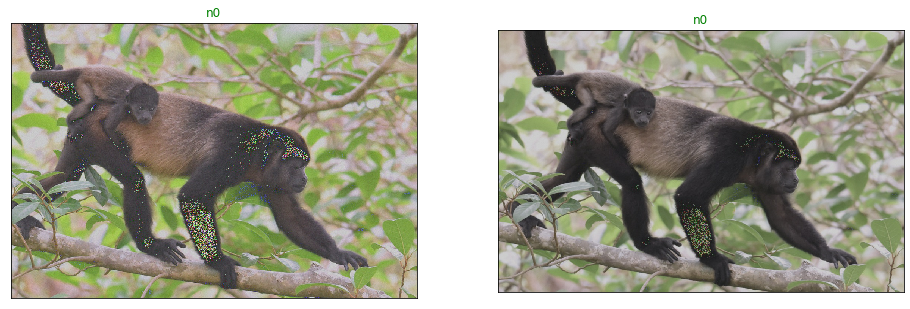

In [13]:
# 数据增强的效果
train_paths = os.listdir(TRAIN_PATH)

fig = plt.figure(figsize=(16, 9))
class_path =train_paths[0]
monkey_paths = os.listdir(os.path.join(TRAIN_PATH,class_path))
for i, img_name in enumerate(['picture_0530.jpg','picture_0531.jpg']):
    ax = fig.add_subplot(1, 2, i + 1, xticks=[], yticks=[])
    monkey_path = os.path.join(TRAIN_PATH,class_path,img_name)
    image=Image.open(monkey_path)
    ax.imshow(image)
    ax.set_title("{}".format(class_path),color="green")